In [1]:
import numpy as np
import matplotlib.pyplot as plt
from multivariateGCI_mr import MultivariateGCI_mr
from multivariateGCI_sr import MultivariateGCI_sr

from qiskit import QuantumRegister, QuantumCircuit, Aer, execute, IBMQ
from qiskit.utils import QuantumInstance
from qiskit.algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit.providers.aer.noise import NoiseModel
from qiskit.test.mock import FakeMontreal, FakeMumbai, FakeGuadalupe, FakeToronto, FakeCasablanca
from qiskit.providers.aer import QasmSimulator 
from qiskit.circuit.library import LinearAmplitudeFunction
from qiskit import transpile

#account = IBMQ.load_account()
#provider = IBMQ.get_provider(hub='ibm-q-research-2', group='politecnico-tor-1', project='main')

### ideas: 
- reset the qubits representing the distribution(s)
- use piecewise rotations to read distribution and directly rotate using offset (single rotation)

In [2]:
import pandas as pd
from itertools import combinations

df = pd.read_csv("Data/sampled_counterparts.csv")
# df = df[((df['pd']>=0.1) & ((1000 < df['lgd dwt']*df['ead']) & (df['lgd dwt']*df['ead'] < 5000000)))]
df =  df.iloc[[38-2, 260-2]] #df.iloc[[38-2, 260-2, 7816-2]] 

F_matrix = pd.read_csv("Data/F_for_sampled_counterparts.csv")
sectors = [1] #[1, 2]
F_values = [[F_matrix.iloc[df.index.values[j]][i-1] for i in sectors] for j in range(len(df))]
# F_values = [[0.55], [0.65], [0.50]] # make F/rhos

In [ ]:
# Build noise model from backend properties
fake_backend = FakeGuadalupe()

simulated = False

# set problem parameters
n_z = 2
z_max = 2

p_zeros = [el['pd'] for _, el in df.iterrows()]
rhos = [el['is']**2 for _, el in df.iterrows()]
lgd = [el['lgd dwt']*el['ead'] for _, el in df.iterrows()]

K = len(p_zeros)

n_shots = 2048
optimization_level = 1
alpha_var = 0.05

print(f'F: {F_values}\nRhos: {np.sqrt(rhos)}\nLgds: {lgd}\np_zeros: {p_zeros}')
df

F: [[0.1580707722], [0.2555327991]]
Rhos: [0.3 0.3]
Lgds: [18406.56224845756, 54807.94141703075]
p_zeros: [0.2565108504, 0.0715568886]


,cluster,pd,lgd dwt,ead,num ctp,sett,is,acca,cod type,cod stato,lgd pag
36,005118_618,0.256511,0.223071,82514.537908,83292,5,0.3,0.000083,0,0,0.187699
258,002116_18,0.071557,0.194311,282063.242107,888,2,0.3,0.019318,0,0,0.157672


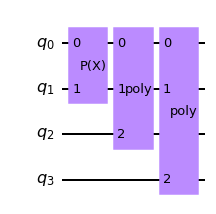

In [4]:
# u = MultivariateGCI_sr(n_z, z_max, p_zeros, rhos, F_values[1])
u = MultivariateGCI_mr(n_z, z_max, p_zeros, rhos, F_values)

# u.decompose().decompose().decompose().decompose().decompose().draw(filename='u_circuit.svg', fold=22)
# print(u.decompose().draw(output='latex_source'))
u.decompose().draw("mpl", filename='Images/u_circuit.svg')

Expected Loss E[L]:                8243.3829
Value at Risk VaR[L]:              54807.9414


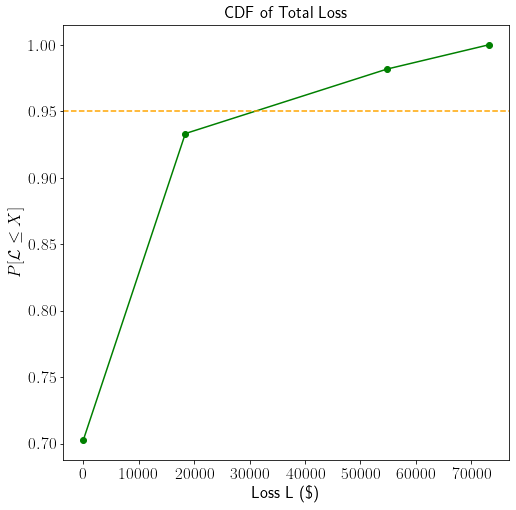

array([0.7026144 , 0.93317148, 0.98169751, 1.        ])

In [5]:
# run the circuit and analyze the results
job = execute(u, backend=Aer.get_backend('statevector_simulator'),) # n_shots=n_shots)

# analyze uncertainty circuit and determine exact solutions
p_z = np.zeros(2**n_z)
p_default = np.zeros(K)
values = []
probabilities = []
num_qubits = u.num_qubits
for i, a in enumerate(np.array(job.result().get_statevector())):
    
    # get binary representation
    b = ('{0:0%sb}' % num_qubits).format(i)
    prob = np.abs(a)**2
    
    # extract value of Z and corresponding probability    
    i_normal = int(b[-n_z:], 2)
    p_z[i_normal] += prob

    # determine overall default probability for k 
    loss = 0
    for k in range(K):
        if b[K - k - 1] == '1':
            p_default[k] += prob
            loss += lgd[k]
    values += [loss]
    probabilities += [prob]   

values = np.array(values)
probabilities = np.array(probabilities)
    
expected_loss = np.dot(values, probabilities)

losses = np.sort(np.unique(values))
pdf = np.zeros(len(losses))
for i, v in enumerate(losses):
    pdf[i] += sum(probabilities[values == v])
cdf = np.cumsum(pdf)

i_var = np.argmax(cdf >= 1-alpha_var)
exact_var = losses[i_var]

print('Expected Loss E[L]:                %.4f' % expected_loss)
print('Value at Risk VaR[L]:              %.4f' % exact_var)

# plot loss CDF
plt.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"] = (8, 8)
plt.plot(np.sort(np.unique(losses)), cdf, 'o-g')
plt.axhline(1-alpha_var, color="orange", linestyle="--")
   
plt.xlabel("Loss L (\$)", size=17)
plt.ylabel(r'$P[\mathcal{L} \leq X]$', size=17) 
plt.title ("CDF of Total Loss", size=17)
plt.xticks(size=17) # plt.xticks(np.sort(np.unique(losses)), np.sort(np.unique(losses)), size=17)
plt.yticks(size=17)
plt.savefig('Images/cdf.svg', dpi=400, bbox_inches = "tight")
plt.show()
cdf

In [12]:
def mapping(decimal_number):
    b = ('{0:0%sb}' % K).format(decimal_number)
    #print(b)
    losses = [loss for i, loss in enumerate(lgd[::-1]) if b[i]=='1']
    #print(losses)
    total_loss = sum(losses)
    return total_loss

def find_breakpoint(x_eval):
    for el in range(0,2**K):
        if mapping(el) <= x_eval:
            if mapping(el+1) >= x_eval:
                return el
    return 0

depth = 'e_loss'

In [13]:
if depth == 'e_loss':
    # define linear objective function for expected loss
    breakpoints = list(range(0,2**K))
    slopes = [0]*len(breakpoints)
    offsets = [mapping(el) for el in breakpoints]
    f_min = 0
    f_max = sum(lgd)
    c_approx = 0.01

    objective_e_loss = LinearAmplitudeFunction(
        K,
        slope=slopes, 
        offset=offsets, 
        # max value that can be reached by the qubit register (will not always be reached)
        domain=(0, 2**K-1),  
        image=(f_min, f_max),
        rescaling_factor=c_approx,
        breakpoints=breakpoints
    )

In [14]:
from qiskit.circuit.library import LinearAmplitudeFunction


def get_cdf_circuit(x_eval):
    
    # define linear objective function for cdf
    breakpoints = list(range(0,2**K))
    slopes = [0]*len(breakpoints)
    # print(values)
    offsets = [1 if mapping(el)<=x_eval else 0 for el in breakpoints]
    f_min = 0
    f_max = 1
    c_approx = 0.01
    
    objective = LinearAmplitudeFunction(
        K,
        slope=slopes, 
        offset=offsets, 
        # max value that can be reached by the qubit register (will not always be reached)
        domain=(0, 2**K-1),  
        image=(f_min, f_max),
        rescaling_factor=c_approx,
        breakpoints=breakpoints
    )

    # define the registers for convenience and readability
    qr_state = QuantumRegister(u.num_qubits, 'state')
    qr_obj = QuantumRegister(1, 'objective')
    ar = QuantumRegister(objective.num_ancillas, "work")  # additional qubits

    # define the circuit
    state_preparation = QuantumCircuit(qr_state, qr_obj, ar, name='A')

    # load the random variable
    state_preparation.append(u.to_gate(), qr_state)

    # linear objective function (does aggregation and comparison)
    if depth == 'e_loss':
        state_preparation.append(objective_e_loss.to_gate(), qr_state[-K:] + qr_obj[:] + ar[:])
        return state_preparation, objective_e_loss
    else:
        state_preparation.append(objective.to_gate(), qr_state[-K:] + qr_obj[:] + ar[:])
        return state_preparation, objective
    
example = 0
state_preparation, objective = get_cdf_circuit(example)
job = execute(state_preparation, backend=Aer.get_backend('statevector_simulator'), shots=2048)

# evaluate resulting statevector
var_prob = 0
for i, a in enumerate(np.array(job.result().get_statevector())):
    b = ('{0:0%sb}' % (u.num_qubits + 1)).format(i)[-(u.num_qubits + 1):]
    prob = np.abs(a)**2
    if b[0] == '1':
        var_prob += prob
if depth == 'e_loss':
    print('Operator Expected Loss' + ' = %.4f' % objective.post_processing(var_prob))
else:
    print('Operator CDF(%s)' % example + ' = %.4f' % objective.post_processing(var_prob))
state_preparation.draw()
# objective.decompose().decompose().draw()

Operator Expected Loss = 8244.4468


┌───────┐      
  state_0: ┤0      ├──────
           │       │      
  state_1: ┤1      ├──────
           │  P(X) │┌────┐
  state_2: ┤2      ├┤0   ├
           │       ││    │
  state_3: ┤3      ├┤1   ├
           └───────┘│    │
objective: ─────────┤2 F ├
                    │    │
   work_0: ─────────┤3   ├
                    │    │
   work_1: ─────────┤4   ├
                    └────┘

In [ ]:
import time
# set target precision and confidence level
epsilon = 0.01/5
alpha = 0.05/5

# Build noise model from backend properties
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research-2', group='politecnico-tor-1', project='main')
backend = provider.get_backend('ibm_perth')
noise_model = NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

qi_ideal = QuantumInstance(Aer.get_backend('aer_simulator'), shots=n_shots*2, 
                           optimization_level=optimization_level, seed_transpiler=42)

# qi_noise = QuantumInstance(provider.get_backend('ibm_perth'), shots=n_shots, 
#                             optimization_level=optimization_level, seed_transpiler=42)

if simulated == False:
    qi_noise = QuantumInstance(backend, shots=n_shots, 
                            optimization_level=optimization_level, seed_transpiler=42)
else:
    qi_noise = QuantumInstance(Aer.get_backend('aer_simulator'), shots=n_shots, 
                           optimization_level=optimization_level, seed_transpiler=42,
                           noise_model=noise_model, coupling_map=coupling_map, basis_gates=basis_gates)

ibmqfactory.load_account:WARNING:2022-05-19 17:59:49,909: Credentials are already in use. The existing account in the session will be replaced.


In [24]:
if depth == 'e_loss':
    start_time = time.time()
    problem = EstimationProblem(state_preparation=state_preparation,
                                objective_qubits=[u.num_qubits],
                                post_processing=objective.post_processing)
    # construct amplitude estimation 
    ae = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi_ideal)
    result = ae.estimate(problem)
    q_samples_ideal = 2**len(result.powers)-1
    # save results
    conf_int_ideal = np.array(result.confidence_interval_processed)
    result_ideal = result.estimation_processed
    runtime_ideal = time.time() - start_time
    ideal_result = result

    print("result with no noise:", result_ideal)

    start_time = time.time()
    problem = EstimationProblem(state_preparation=state_preparation,
                                objective_qubits=[u.num_qubits],
                                post_processing=objective.post_processing)
    # construct amplitude estimation
    ae = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi_noise)
    result = ae.estimate(problem)
    q_samples_noisy = 2**len(result.powers)-1

    # print results
    conf_int_noisy = np.array(result.confidence_interval_processed)
    result_noisy = result.estimation_processed
    runtime_noisy = time.time() - start_time
    noisy_result = result
    
    print("\nresult with noise:", result_noisy)

result with no noise: 7856.136651269117


In [11]:
if depth == 'e_loss':
    ae_circuit = ae.construct_circuit(problem, k=2)
    tr_ae_circuit = transpile(ae_circuit, optimization_level=optimization_level, backend=fake_backend, seed_transpiler=42)
    print(tr_ae_circuit.depth()) # Return circuit depth (i.e., length of critical path).
    print(tr_ae_circuit.size()) # Returns total number of instructions in circuit.

    # noise_model = NoiseModel.from_backend(QasmSimulator.from_backend(fake_backend))
    # basis_gates = noise_model.basis_gates
    # tr_ae_circuit = transpile(ae_circuit, basis_gates=basis_gates, optimization_level=optimization_level)

    ae_circuit.decompose().draw("mpl", style="iqx")
    #plot_circuit_layout(tr_ae_circuit, fake_backend)
    # ae_circuit.decompose().decompose().decompose().decompose().decompose().decompose().decompose().decompose().decompose().size()

In [12]:
def run_ae_for_cdf(x_eval, epsilon=epsilon, alpha=alpha, noise=False):

    # construct amplitude estimation 
    state_preparation, objective = get_cdf_circuit(x_eval)
    
    if noise == False:
        qi = QuantumInstance(Aer.get_backend('statevector_simulator'),) # shots=n_shots, )
                               #optimization_level=optimization_level, seed_transpiler=42)
    else:
        qi = QuantumInstance(QasmSimulator.from_backend(fake_backend), shots=n_shots, )
                               #optimization_level=optimization_level, seed_transpiler=42)
        
    problem = EstimationProblem(state_preparation=state_preparation,
                                objective_qubits=[u.num_qubits])
    
    ae_var = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)
    #ae_circuit = ae_var.construct_circuit(problem, k=50000, measurement=False)
    result_var = ae_var.estimate(problem)
    # print(result_var.num_oracle_queries)
    # print(objective.post_processing(result_var.estimation))
    return objective.post_processing(result_var.estimation)#, ae_circuit, result_var

In [13]:
cdf = [run_ae_for_cdf(el, epsilon=epsilon, alpha=alpha) for el in np.sort(np.unique(losses))] 
# print(cdf)

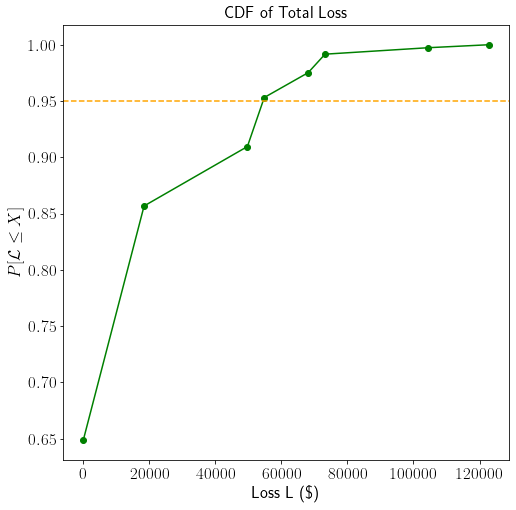

In [14]:
# plot loss CDF
plt.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"] = (8, 8)
plt.plot(np.sort(np.unique(losses)), cdf, 'o-g')
plt.axhline(1-alpha_var, color="orange", linestyle="--")
   
plt.xlabel("Loss L (\$)", size=17)
plt.ylabel(r'$P[\mathcal{L} \leq X]$', size=17) 
plt.title ("CDF of Total Loss", size=17)
plt.xticks(size=17) # plt.xticks(np.sort(np.unique(losses)), np.sort(np.unique(losses)), size=17)
plt.yticks(size=17)
plt.savefig('Images/cdf.svg', dpi=400, bbox_inches = "tight")
plt.show()

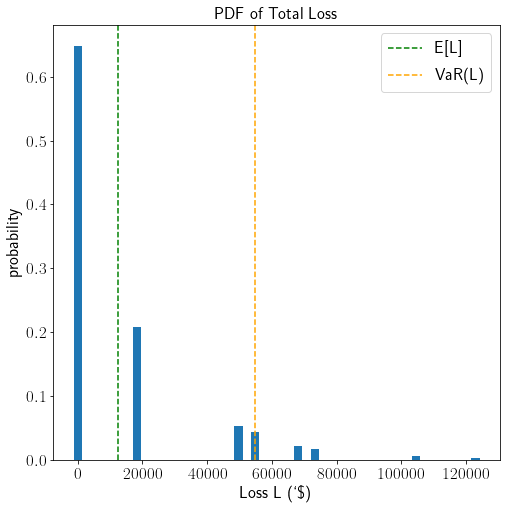

In [15]:
# plot loss PDF, expected loss, var, and evar
pdf = [el-np.sum(cdf[i-1:i]) for i, el in enumerate(cdf)]
plt.bar(np.sort(np.unique(losses)), pdf, align = "center", width = 2500)
plt.axvline(expected_loss, color="green", linestyle="--", label="E[L]") 
plt.axvline(exact_var, color="orange", linestyle="--", label="VaR(L)")
 
plt.legend(fontsize=17)
plt.xlabel("Loss L (`\$)", size=17)
plt.ylabel("probability", size=17)
plt.title ("PDF of Total Loss", size=17)
plt.xticks(size=17)
plt.yticks(size=17)
plt.savefig('Images/pdf.svg', dpi=300, bbox_inches = "tight")
plt.show()

In [18]:
def bisection_search(objective, target_value, low_level, high_level, low_value=None, high_value=None):
    """
    Determines the smallest level such that the objective value is still larger than the target
    :param objective: objective function
    :param target: target value
    :param low_level: lowest level to be considered
    :param high_level: highest level to be considered
    :param low_value: value of lowest level (will be evaluated if set to None)
    :param high_value: value of highest level (will be evaluated if set to None)
    :return: dictionary with level, value, num_eval
    """

    # check whether low and high values are given and evaluated them otherwise
    print('--------------------------------------------------------------------')
    print('start bisection search for target value %.3f' % target_value)
    print('--------------------------------------------------------------------')
    num_eval = 0
    if low_value is None:
        low_value = objective(low_level)
        num_eval += 1
    if high_value is None:
        high_value = objective(high_level)
        num_eval += 1    
        
    # check if low_value already satisfies the condition
    if low_value > target_value:
        return {'level': low_level, 'value': low_value, 'num_eval': num_eval, 'comment': 'returned low value'}
    elif low_value == target_value:
        return {'level': low_level, 'value': low_value, 'num_eval': num_eval, 'comment': 'success'}

    # check if high_value is above target
    if high_value < target_value:
        return {'level': high_level, 'value': high_value, 'num_eval': num_eval, 'comment': 'returned low value'}
    elif high_value == target_value:
        return {'level': high_level, 'value': high_value, 'num_eval': num_eval, 'comment': 'success'}

    # perform bisection search until
    print('low_level    low_value    level    value     high_level    high_value')
    print('--------------------------------------------------------------------')
    while high_level - low_level > 1: #risoluzione

        level = (high_level + low_level) / 2.0
        num_eval += 1
        value = objective(level)

        print('%.2f     %.3f      %.2f   %.3f      %.2f       %.3f' \
              % (low_level, low_value, level, value, high_level, high_value))

        if value >= target_value:
            high_level = level
            high_value = value
        else:
            low_level = level
            low_value = value

    # return high value after bisection search
    print('--------------------------------------------------------------------')
    print('finished bisection search')
    print('--------------------------------------------------------------------')
    return {'level': high_level, 'value': high_value, 'num_eval': num_eval, 'comment': 'success'}

In [19]:
# run bisection search to determine VaR

objective_ideal = lambda x: run_ae_for_cdf(x)
objective_noisy = lambda x: run_ae_for_cdf(x, noise=True)

bisection_result_ideal = bisection_search(objective_ideal, 1-alpha_var, min(losses)-0.001, max(losses), low_value=0, high_value=1)
# bisection_result_noisy = bisection_search(objective_noisy, 1-alpha_var, min(losses)-0.1, max(losses), low_value=0, high_value=1)

var = bisection_result_ideal['level']
# var_noisy = bisection_result_noisy['level']

print('Estimated Value at Risk: %.3f' % var)
# print('Estimated (w noise) Value at Risk: %.3f' % var_noisy)
print('Exact Value at Risk:     %.3f' % exact_var)
print('Estimated Probability:    %.3f' % bisection_result_ideal['value'])

--------------------------------------------------------------------
start bisection search for target value 0.950
--------------------------------------------------------------------
low_level    low_value    level    value     high_level    high_value
--------------------------------------------------------------------
-0.00     0.000      61453.11   0.953      122906.21       1.000
-0.00     0.000      30726.55   0.857      61453.11       0.953
30726.55     0.857      46089.83   0.857      61453.11       0.953
46089.83     0.857      53771.47   0.910      61453.11       0.953
53771.47     0.910      57612.29   0.953      61453.11       0.953
53771.47     0.910      55691.88   0.953      57612.29       0.953
53771.47     0.910      54731.67   0.910      55691.88       0.953
54731.67     0.910      55211.78   0.953      55691.88       0.953
54731.67     0.910      54971.72   0.953      55211.78       0.953
54731.67     0.910      54851.70   0.953      54971.72       0.953
54731.67    

In [48]:
# from qiskit.circuit.library import PiecewiseLinearPauliRotations

# rot = PiecewiseLinearPauliRotations(2, [0, 1, 2, 3], [0,0,0,0], [1,2,3,4])
# rot2 = PiecewiseLinearPauliRotations(2, [0, 1, 2, 3], [0,0,0,0], [5,2,3,4])


# inner = QuantumCircuit(8, name="P(X)")
# inner.append(rot.to_gate(), [0,1,2,4,5])
# inner.append(rot2.to_gate(), [0,1,3,4,5])
# print(inner.draw())

# job = execute(inner, backend=Aer.get_backend('statevector_simulator'), shots=2048)

# var_prob = 0
# job.result().get_counts()
